In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

In [50]:
train_df = pd.read_csv("./jinnan_round1_train_20181227.csv")
test_df = pd.read_csv("./jinnan_round1_testA_20181227.csv")

In [51]:
views = []
for col in train_df.columns:
    views.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,96,96.991404,float64
7,A7,75,89,89.326648,object
8,A8,8,89,89.326648,float64
39,B11,37,60,60.816619,object
38,B10,180,17,17.478510,object
3,A3,3,3,95.702006,float64
0,sample id,1396,0,0.071633,object
33,B5,60,0,17.550143,object
26,A26,88,0,18.982808,object
27,A27,13,0,45.128940,int64


In [52]:
views = []
for col in test_df.columns:
    views.append((col, test_df[col].nunique(), test_df[col].isnull().sum() * 100 / test_df.shape[0], test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, test_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,98,98.000000,float64
7,A7,15,88,88.000000,object
8,A8,2,88,88.000000,float64
39,B11,11,59,59.333333,object
38,B10,50,14,14.666667,object
3,A3,2,2,97.333333,float64
0,sample id,150,0,0.666667,object
32,B4,51,0,20.666667,object
26,A26,41,0,21.333333,object
27,A27,11,0,47.333333,float64


In [53]:
for df in [train_df, test_df]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

features = list(train_df.columns)
for col in train_df.columns:
    rate = train_df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.95:
        features.remove(col)
train_df = train_df[features]
features.remove('score')
test_df = test_df[features]

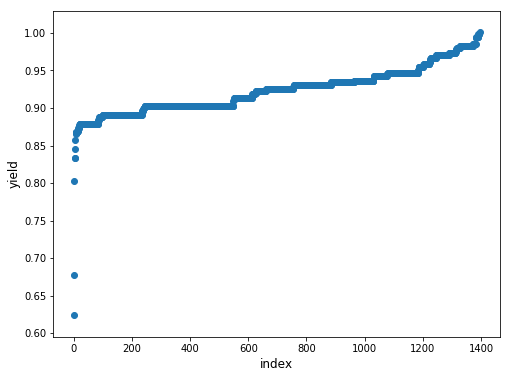

In [54]:
target_col = 'score'
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

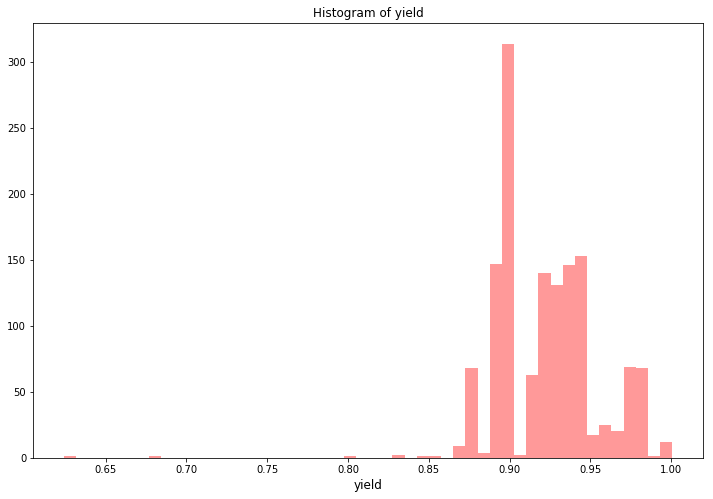

In [55]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [56]:
train_df = train_df[train_df[target_col]>0.87]

In [57]:
def TimeToInt(str, previous = 0):
    now = 0
    try:
        time = re.split("[:,；,;]",str)
        now = (int(time[0]) * 60 + int(time[1])) * 60
        if now < previous:
            now += 86400
    except:
        now = previous
    return now

def getInt(str):
    val = str.split(":")
    return int(val[0]) * 60 + int(val[1])

def TimeToDuration(str):
    duration = 0
    try:
        time = str.split("-")
        duration = getInt(time[1]) - getInt(time[0])
    except:
        duration = 0
    if duration < 0:
        duration += 24 * 60
    return duration

In [58]:
for df in [train_df, test_df]:
    
    df['timeA5'] = df['A5'].apply(lambda x: TimeToInt(x))
    df['timeA9'] = df.apply(lambda x: TimeToInt(x.A9, x.timeA5), axis = 1)
    df['timeA11'] = df.apply(lambda x: TimeToInt(x.A11, x.timeA9), axis = 1)
    df['timeA14'] = df.apply(lambda x: TimeToInt(x.A14, x.timeA11), axis = 1)
    df['timeA16'] = df.apply(lambda x: TimeToInt(x.A16, x.timeA14), axis = 1)
    df['timeA24'] = df.apply(lambda x: TimeToInt(x.A24, x.timeA16), axis = 1)
    df['timeA26'] = df.apply(lambda x: TimeToInt(x.A26, x.timeA24), axis = 1)
    df['timeB5'] = df.apply(lambda x: TimeToInt(x.B5, x.timeA26), axis = 1)
    df['timeB7'] = df.apply(lambda x: TimeToInt(x.B7, x.timeB5), axis = 1)
    df = df.drop(['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7'], axis=1)
    col = ['timeA5','timeA9','timeA11','timeA14','timeA16','timeA24','timeA26','timeB5','timeB7']
    df[col] = df[col].fillna(0)

    df['durationA20'] = df['A20'].apply(lambda x: TimeToDuration(x))
    df['durationA28'] = df['A28'].apply(lambda x: TimeToDuration(x))
    df['durationB4'] = df['B4'].apply(lambda x: TimeToDuration(x))
    df['durationB9'] = df['B9'].apply(lambda x: TimeToDuration(x))
    df['durationB10'] = df['B10'].apply(lambda x: TimeToDuration(x))
    df['durationB11'] = df['B11'].apply(lambda x: TimeToDuration(x))
    df = df.drop(['A20', 'A28', 'B4', 'B9', 'B10', 'B11'], axis=1)
    col = ['durationA20','durationA28','durationB4','durationB9','durationB10','durationB11']
    df[col] = df[col].fillna(0)

In [60]:
col = ['A6','A8','A10','A12','A15','A17','A19','A21','A22','A25','A27','B1','B6','B8','B12','B14']
df[col] = df[col].fillna(0)

In [61]:
def toFloat(str):
    try:
        return float(str)
    except:
        return float(0)
train_set = train_df
train_set.loc[train_set['A25'].apply(lambda x: toFloat(x))]
train_set.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,...,score,timeA5,timeA9,timeA11,timeA14,timeA16,timeA24,timeA26,timeB5,timeB7
0,sample_1528,13:30:00,38.0,NaN,NaN,15:30:00,100,16:30:00,102,17:30:00,...,0.879,0,0,0,0,0,0,0,0,0
1,sample_1698,14:00:00,29.0,NaN,NaN,16:00:00,101,17:00:00,103,18:00:00,...,0.902,0,0,0,0,0,0,0,0,0
2,sample_639,14:00:00,29.0,NaN,NaN,16:00:00,102,17:00:00,103,18:00:00,...,0.936,0,0,0,0,0,0,0,0,0
3,sample_483,1:30:00,38.0,NaN,NaN,3:00:00,100,4:00:00,102,5:00:00,...,0.902,0,0,0,0,0,0,0,0,0
4,sample_617,22:00:00,29.0,NaN,NaN,0:00:00,101,1:00:00,103,2:00:00,...,0.983,0,0,0,0,0,0,0,0,0


In [62]:
target = train_df['score']
del train_df['score']
data = pd.concat([train_df,test_df],axis=0,ignore_index=True)
data = data.fillna(-1)

cate_columns = [f for f in data.columns if f != 'sample id']

#label encoder
for f in cate_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train_df.shape[0]]
test  = data[train_df.shape[0]:]

# one-hot
X_train = pd.DataFrame()
X_test = pd.DataFrame()
enc = OneHotEncoder(categories='auto')
for f in cate_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')

In [63]:
y_train = target.values

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

# 五折交叉验证
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, 
                    trn_data, 
                    num_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)))


fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000292726	valid_1's l2: 0.000305259
[400]	training's l2: 0.000229706	valid_1's l2: 0.000243251
[600]	training's l2: 0.00020581	valid_1's l2: 0.000222861
[800]	training's l2: 0.000193988	valid_1's l2: 0.000213484
[1000]	training's l2: 0.00018671	valid_1's l2: 0.000207704
[1200]	training's l2: 0.000181789	valid_1's l2: 0.000203713
[1400]	training's l2: 0.000178356	valid_1's l2: 0.00020122
[1600]	training's l2: 0.000175611	valid_1's l2: 0.000199216
[1800]	training's l2: 0.000173227	valid_1's l2: 0.000197511
[2000]	training's l2: 0.000171303	valid_1's l2: 0.000196444
[2200]	training's l2: 0.000169431	valid_1's l2: 0.000195298
[2400]	training's l2: 0.00016797	valid_1's l2: 0.000194305
[2600]	training's l2: 0.000166587	valid_1's l2: 0.000193542
[2800]	training's l2: 0.000165336	valid_1's l2: 0.000192784
[3000]	training's l2: 0.00016414	valid_1's l2: 0.00019231
Early stopping, best iteration is:
[29

In [64]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.5f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422934	valid_data-rmse:0.423824
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.257112	valid_data-rmse:0.258116
[200]	train-rmse:0.156822	valid_data-rmse:0.15794
[300]	train-rmse:0.096183	valid_data-rmse:0.097345
[400]	train-rmse:0.059628	valid_data-rmse:0.06076
[500]	train-rmse:0.037746	valid_data-rmse:0.038929
[600]	train-rmse:0.02479	valid_data-rmse:0.026338
[700]	train-rmse:0.017223	valid_data-rmse:0.019556
[800]	train-rmse:0.012826	valid_data-rmse:0.01613
[900]	train-rmse:0.010343	valid_data-rmse:0.014568
[1000]	train-rmse:0.008904	valid_data-rmse:0.013892
[1100]	train-rmse:0.008077	valid_data-rmse:0.013617
[1200]	train-rmse:0.007553	valid_data-rmse:0.013521
[1300]	train-rmse:0.007222	valid_data-rmse:0.013498
[1400]	train-rmse:0.007	valid_data-rmse:0.01351
[1500]	train-rmse:0.006836	valid_data-rmse:0.013538
Stopping. Best iteratio

In [65]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.5f}".format(mean_squared_error(target.values, oof_stack)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.00019 


In [66]:
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("submission.csv", index=False, header=None)